Regressionanalysis

Step 1: Load and inspect the data

In [166]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
import itertools



In [167]:

file_path = 'wggesucht_scraped_24_05_cleaned.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
display(data.head())
print(data.shape)
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

,Size,PriceTotal,Deposit,OnlineSince,Adress,AmountofIcons,AmountofIconsNeeded,Titel_length,analysis_det,analysis_desr,analysis_desl,analysis_deso
0,12,670,0,1.0,3,3,0,38,0.4588,0.0000,0.8625,0.0772
1,20,350,600,1.0,4,12,0,48,0.0000,0.0000,-0.9020,-0.5994
2,11,790,2200,1.0,3,8,4,42,0.0000,0.8122,0.3400,0.0000
3,14,970,2673,1.0,3,7,3,46,0.0000,-0.9097,0.0000,0.0000
4,14,800,2145,1.0,3,12,5,52,0.0000,-0.5255,0.0000,0.0000


(1135, 12)
Missing Values:
 Size                   0
PriceTotal             0
Deposit                0
OnlineSince            0
Adress                 0
AmountofIcons          0
AmountofIconsNeeded    0
Titel_length           0
analysis_det           0
analysis_desr          0
analysis_desl          0
analysis_deso          0
dtype: int64


Step 2: Create a correlation matrix


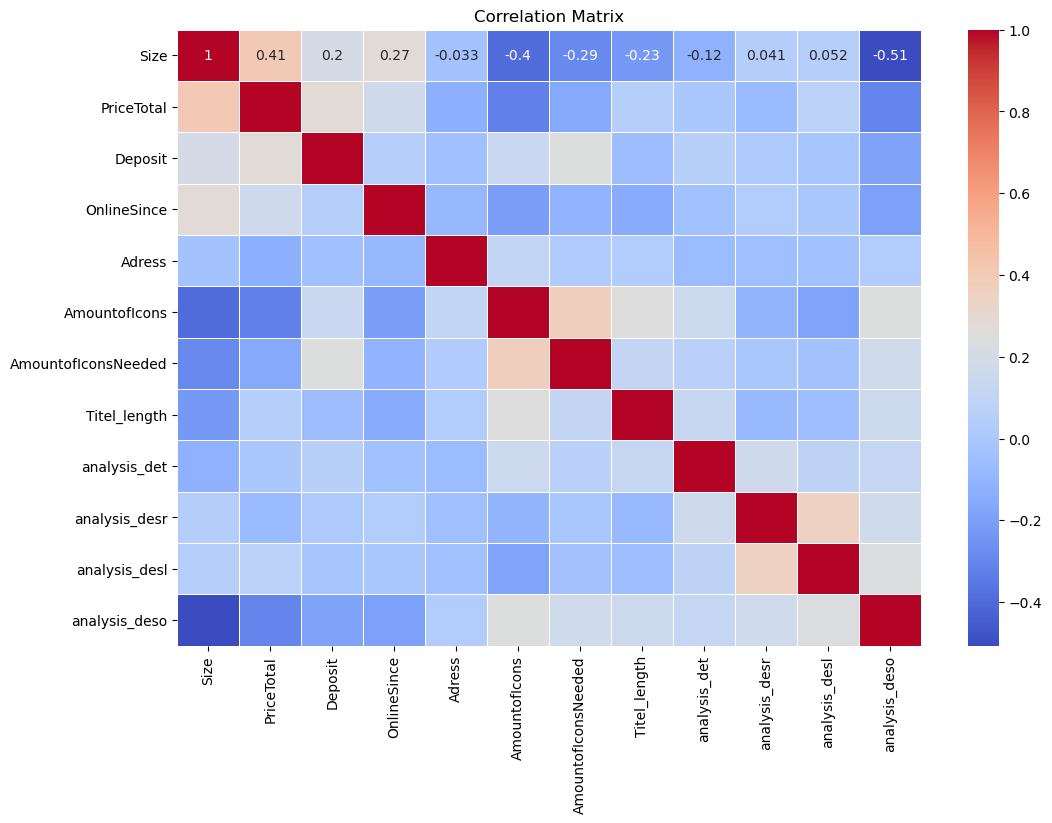

In [168]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Step 3: Simple regression model: PriceTotal vs. Size


In [169]:

# Simple regression model
X_simple = data['Size']
y = data['PriceTotal']
X_simple = sm.add_constant(X_simple)
model_simple = sm.OLS(y, X_simple).fit()
print(model_simple.summary())



                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     227.1
Date:                Tue, 28 May 2024   Prob (F-statistic):           6.54e-47
Time:                        11:42:03   Log-Likelihood:                -7717.0
No. Observations:                1135   AIC:                         1.544e+04
Df Residuals:                    1133   BIC:                         1.545e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        739.6354      8.464     87.382      0.0

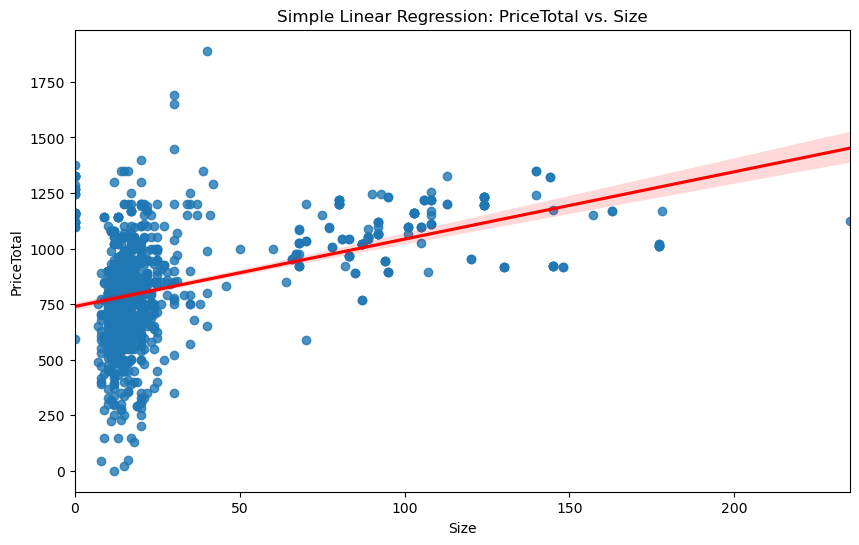

In [170]:
# Plot the simple regression model
plt.figure(figsize=(10, 6))
sns.regplot(x='Size', y='PriceTotal', data=data, line_kws={'color': 'red'})
plt.title('Simple Linear Regression: PriceTotal vs. Size')
plt.xlabel('Size')
plt.ylabel('PriceTotal')
plt.show()

Step 4: Multiple regression models: PriceTotal vs. all independent variables


In [171]:
# Multiple regression models
X = data.drop(columns=['PriceTotal'])
y = data['PriceTotal']
X = sm.add_constant(X)
model_multiple = sm.OLS(y, X).fit()
print(model_multiple.summary())


                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     50.91
Date:                Tue, 28 May 2024   Prob (F-statistic):           7.36e-91
Time:                        11:42:03   Log-Likelihood:                -7591.1
No. Observations:                1135   AIC:                         1.521e+04
Df Residuals:                    1123   BIC:                         1.527e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 700.8294    

On the search for a better model determint on the R Squared values

Interesting enough: It find the full spec model with every data column involved.

In [172]:
def find_best_model(data, dependent_var):
    # Separate the dependent variable and independent variables
    y = data[dependent_var]
    X = data.drop(columns=[dependent_var])
    X = sm.add_constant(X)
    
    # Initialize variables to store the best model
    best_r_squared = -1
    best_model = None
    best_combination = None
    
    # Iterate over all combinations of independent variables
    for i in range(1, len(X.columns)):
        for combo in itertools.combinations(X.columns[1:], i):
            X_subset = X[['const'] + list(combo)]
            model = sm.OLS(y, X_subset).fit()
            r_squared = model.rsquared
            
            # Update the best model if current model is better
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_model = model
                best_combination = combo
    
    return best_model, best_combination, best_r_squared

# Example usage
data = pd.read_csv(file_path)

# Find the best model for 'PriceTotal'
best_model, best_combination, best_r_squared = find_best_model(data, 'PriceTotal')
print(f"Best R-squared: {best_r_squared}")
print(f"Best combination of independent variables: {best_combination}")
print(best_model.summary())

Best R-squared: 0.3327236782927374
Best combination of independent variables: ('Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'AmountofIconsNeeded', 'Titel_length', 'analysis_det', 'analysis_desr', 'analysis_desl', 'analysis_deso')
                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     50.91
Date:                Tue, 28 May 2024   Prob (F-statistic):           7.36e-91
Time:                        11:42:05   Log-Likelihood:                -7591.1
No. Observations:                1135   AIC:                         1.521e+04
Df Residuals:                    1123   BIC:                         1.527e+04
Df Model:                          11                                         
Covariance Type:            nonrobust      

Now similiar algorithm but it now penitilizes too many axplainitory varialbes on a 0.02 level.

In [173]:
def find_best_model(data, dependent_var):
    # Separate the dependent variable and independent variables
    y = data[dependent_var]
    X = data.drop(columns=[dependent_var])
    X = sm.add_constant(X)
    
    # Initialize variables to store the best model
    best_r_squared = -1
    best_model = None
    best_combination = None
    best_num_vars = float('inf')
    current_subset = None
    
    # Iterate over all combinations of independent variables
    for i in range(1, len(X.columns)):
        for combo in itertools.combinations(X.columns[1:], i):
            X_subset = X[['const'] + list(combo)]
            model = sm.OLS(y, X_subset).fit()
            r_squared = model.rsquared
            # Update the best model if current model is better
            if (r_squared  > best_r_squared + 0.02) or (r_squared >= best_r_squared - 0.02 and len(combo) < best_num_vars):
                best_r_squared = r_squared
                best_model = model
                best_combination = combo
                best_num_vars = len(combo)
                current_subset = X_subset
    
    return best_model, best_combination, best_r_squared, current_subset

# Example usage
data = pd.read_csv(file_path)

# Find the best model for 'PriceTotal'
best_model, best_combination, best_r_squared, X_Best = find_best_model(data, 'PriceTotal')
print(f"Best R-squared: {best_r_squared}")
print(f"Best combination of independent variables: {best_combination}")
print(best_model.summary())


Best R-squared: 0.3172534241615913
Best combination of independent variables: ('Size', 'Deposit', 'OnlineSince', 'Adress', 'AmountofIcons', 'Titel_length', 'analysis_desr')
                            OLS Regression Results                            
Dep. Variable:             PriceTotal   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     74.81
Date:                Tue, 28 May 2024   Prob (F-statistic):           5.27e-89
Time:                        11:42:07   Log-Likelihood:                -7604.1
No. Observations:                1135   AIC:                         1.522e+04
Df Residuals:                    1127   BIC:                         1.526e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err  

Although there is a minor loss of quality in the model by 0.015, we now have a way smaller model with some of the more non explainatory values excluded.

Step 6: Check assumptions

1. Correct model specification
The model specification is based on theoretical considerations and prior research.

2. No perfect multicollinearity
Multicollinearity is checked using VIF values. VIF values below 5 indicate no serious multicollinearity.

In [174]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Values:\n", vif_data)


vif_data = pd.DataFrame()
vif_data['Feature'] = X_Best.columns
vif_data['VIF'] = [variance_inflation_factor(X_Best.values, i) for i in range(X_Best.shape[1])]
print("VIF Values:\n", vif_data)


VIF Values:
                 Feature        VIF
0                 const  14.278830
1                  Size   1.714732
2               Deposit   1.228074
3           OnlineSince   1.110298
4                Adress   1.028878
5         AmountofIcons   1.487499
6   AmountofIconsNeeded   1.288096
7          Titel_length   1.115236
8          analysis_det   1.089573
9         analysis_desr   1.209306
10        analysis_desl   1.261215
11        analysis_deso   1.569687
VIF Values:
          Feature        VIF
0          const  14.014462
1           Size   1.357942
2        Deposit   1.116995
3    OnlineSince   1.105243
4         Adress   1.022309
5  AmountofIcons   1.341833
6   Titel_length   1.102145
7  analysis_desr   1.016212


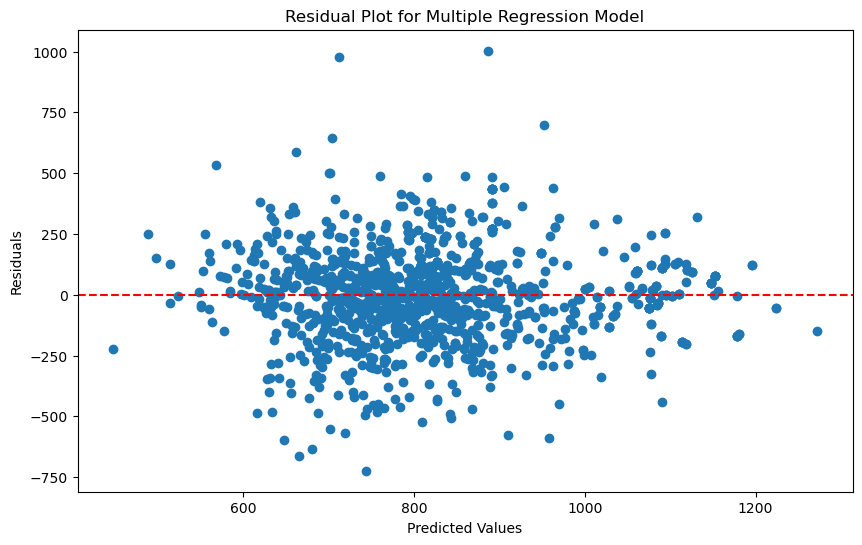

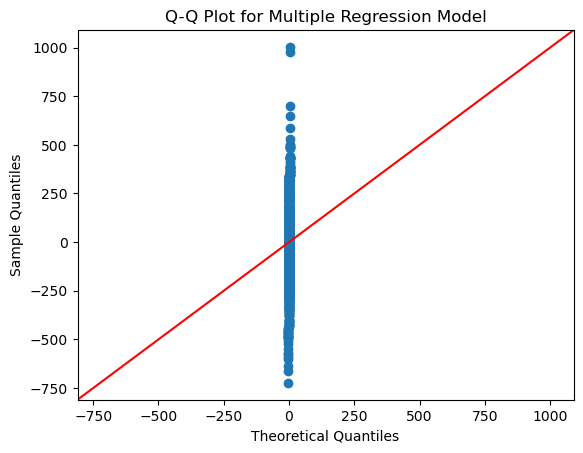

In [175]:
# Residual plot for the multiple regression model
predictions = model_multiple.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(predictions, model_multiple.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Multiple Regression Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q plot for the multiple regression model
sm.qqplot(model_multiple.resid, line='45')
plt.title('Q-Q Plot for Multiple Regression Model')
plt.show()


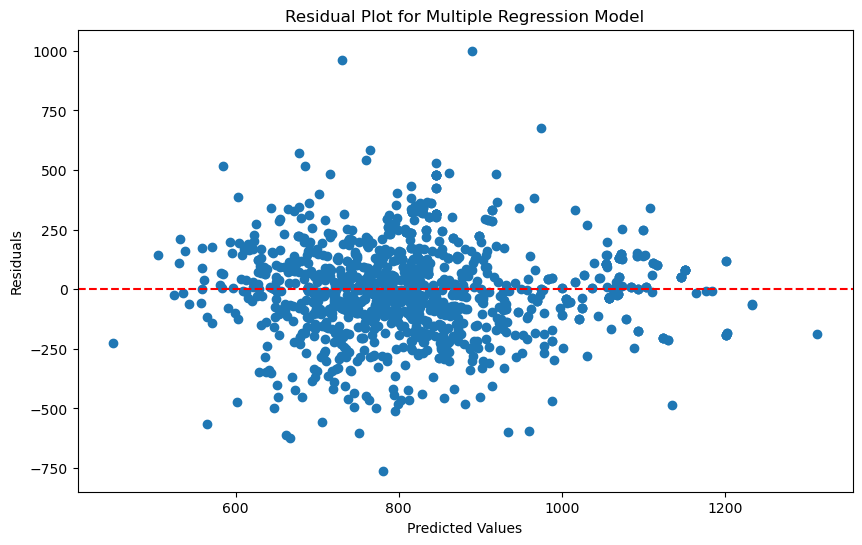

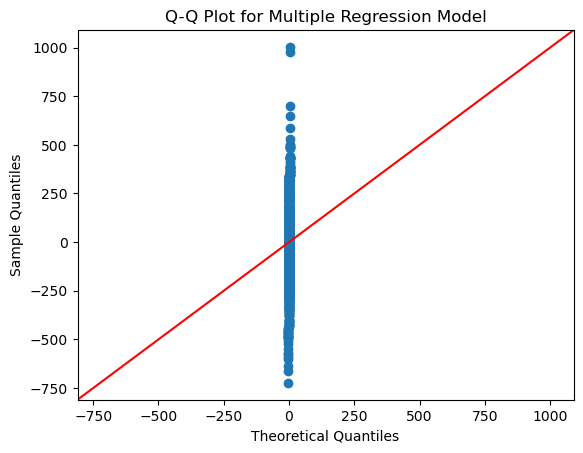

In [176]:
# Residual plot for the multiple regression model
best_predictions = best_model.predict(X_Best)

plt.figure(figsize=(10, 6))
plt.scatter(best_predictions, best_model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Multiple Regression Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Q-Q plot for the multiple regression model
sm.qqplot(model_multiple.resid, line='45')
plt.title('Q-Q Plot for Multiple Regression Model')
plt.show()

3. Expected value of the error is zero
Check the mean of the residuals:

In [177]:
# Mean of residuals
mean_residuals = model_multiple.resid.mean()
print("Mean of residuals:", mean_residuals)

mean_residuals = best_model.resid.mean()
print("Best Model => Mean of residuals:", mean_residuals)



Mean of residuals: 5.3673208804518015e-12
Best Model => Mean of residuals: 1.4566939920576757e-12


4. Homoscedasticity
Check graphically or using the Breusch-Pagan test:


In [178]:
bp_test = het_breuschpagan(model_multiple.resid, model_multiple.model.exog)
print("Breusch-Pagan test p-value:", bp_test[1])

bp_test = het_breuschpagan(best_model.resid, best_model.model.exog)
print("Best Model => Breusch-Pagan test p-value:", bp_test[1])


Breusch-Pagan test p-value: 1.4462190208267032e-13
Best Model => Breusch-Pagan test p-value: 2.9453732677793553e-12


Graphical Version

Normal Model:

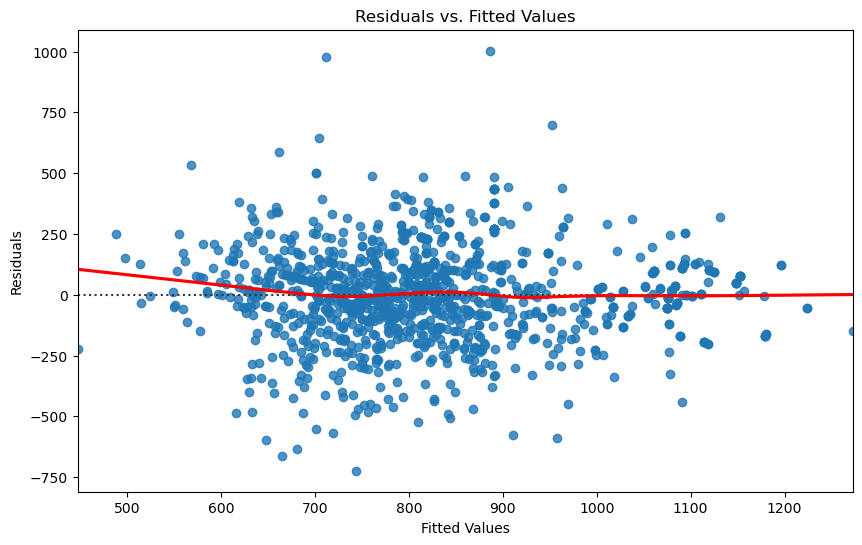

In [179]:
# Residuals vs. Fitted values plot
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=model_multiple.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Best Model

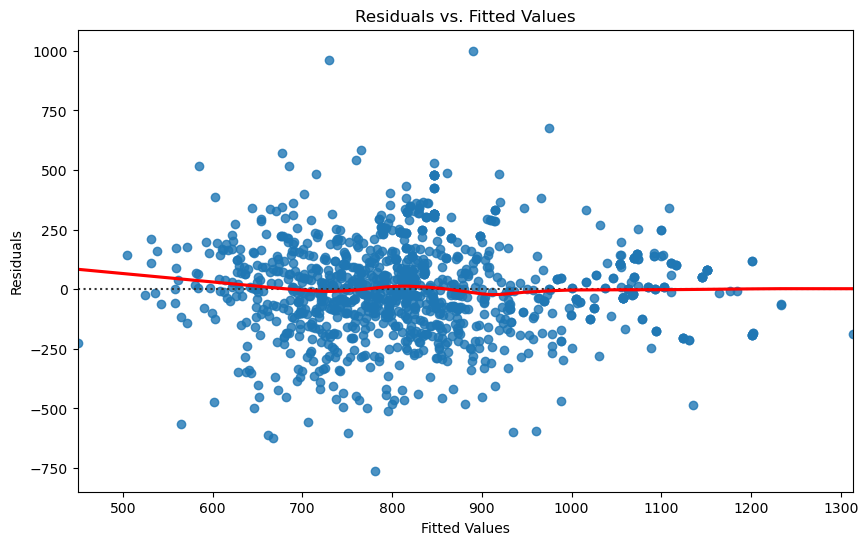

In [180]:
# Residuals vs. Fitted values plot
plt.figure(figsize=(10, 6))
sns.residplot(x=best_predictions, y=best_model.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

5. No correlation between independent variables and error term
This assumption is theoretical and requires ensuring no omitted variable bias.



6. No autocorrelation
Use the Durbin-Watson test:

In [181]:
dw_test = durbin_watson(model_multiple.resid)
print("Durbin-Watson test statistic:", dw_test)


dw_test = durbin_watson(best_model.resid)
print("Best Model => Durbin-Watson test statistic:", dw_test)


Durbin-Watson test statistic: 1.880083220462109
Best Model => Durbin-Watson test statistic: 1.8467025331887406


7. Errors are normally distributed
Check graphically or using the Shapiro-Wilk test:

In [182]:
shapiro_test = shapiro(model_multiple.resid)
print("Best Model => Shapiro-Wilk test p-value:", shapiro_test[1])


shapiro_test = shapiro(best_model.resid)
print("Best Model => Shapiro-Wilk test p-value:", shapiro_test[1])


Best Model => Shapiro-Wilk test p-value: 2.0016603929917665e-09
Best Model => Shapiro-Wilk test p-value: 6.841488264797135e-09
